In [1]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torchsummary
from torch.optim.lr_scheduler import StepLR 

import os, sys
import tempfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('Pytorch version:[%s].'%(torch.__version__))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('[%s].'%(device))

Pytorch version:[1.13.0].
[cuda:0].


In [2]:
__file__ = '/home/seongwoo/workspace/SLACK-util-test/model_noti/slack_handler/'
# sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/seongwoo/workspace/SLACK-util-test/model_noti'))))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(__file__))))
# from slack_handler

In [3]:
from slack_handler.slack_channel_noti import post_message
from slack_handler import config
from slack_handler.slack_channel_noti import post_file

In [4]:
def send_plot(train_loss_list, val_loss_list):
    with tempfile.TemporaryDirectory() as tempDir:
        if os.path.exists(tempDir):
            plt.plot(train_loss_list)
            plt.plot(val_loss_list)
            plt.savefig(f'{tempDir}/val_plot.png')
            with open(f'{tempDir}/val_plot.png', 'rb') as f:
                content = f.read()
                post_file(config.user_token, config.channel_id, f.name, content)

## Set hyper parameter

In [5]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.01
LAYERS = 100

## Prepare dataset

In [7]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       # transforms.RandomVerticalFlip(),
                                       # transforms.RandomAffine(180, shear=20),
                                       transforms.ToTensor(), # 정규화 결과가 0 ~ 1
                                    #    transforms.Resize((224, 224)),
                                       transforms.RandomErasing(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])

                                    #   transforms.CenterCrop(224),
val_transforms = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])


DATASET_PATH = './data'
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(DATASET_PATH + '/val', transform=val_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
val_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print('preparing dataset Done')

preparing dataset Done


In [8]:
train_labels_map = {v:k for k, v in train_data.class_to_idx.items()}
test_labels_map = {v:k for k, v in test_data.class_to_idx.items()}

In [9]:
data_iter = iter(test_iter)
# next(data_iter)
images, labels = next(data_iter)

In [10]:
images[0].shape

torch.Size([3, 224, 224])

## our model

In [11]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)

In [12]:
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

In [13]:
class DenseNet(nn.Module):
    def __init__(self, nblocks, num_classes, growth_rate=12, reduction=0.5, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121(num_classes):
    return DenseNet([6, 12, 24, 16], num_classes)

### train

In [14]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) 
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()
    # scheduler.step()

### evaluate

In [15]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [20]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs):
    train_loss_list = []
    val_loss_list = []

    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, train Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, val Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        train_loss_list.append(round(train_loss, 5))
        val_loss_list.append(round(val_loss, 5))

        if epoch % 40 == 0:
            post_msg = f'LR: {LEARNING_RATE}\nEPOCH : {epoch}\ntrain loss : {train_loss}\nval loss : {val_loss}\nbest val acc : {best_acc}'
            res_ = post_message(config.token, config.channel_id, post_msg)
            send_plot(train_loss_list, val_loss_list)

    model.load_state_dict(best_model_wts)  
    return model, train_loss_list, val_loss_list
 



In [17]:
def adjust_learning_rate(optimizer, epoch):
    lr = LEARNING_RATE
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [18]:
len(train_labels_map)

120

In [19]:
model = DenseNet_121(len(train_labels_map)).to(device)

torchsummary.summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]           3,552
         MaxPool2d-2           [-1, 24, 56, 56]               0
       BatchNorm2d-3           [-1, 24, 56, 56]              48
              ReLU-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 48, 56, 56]           1,152
       BatchNorm2d-6           [-1, 48, 56, 56]              96
              ReLU-7           [-1, 48, 56, 56]               0
            Conv2d-8           [-1, 12, 56, 56]           5,184
        BottleNeck-9           [-1, 36, 56, 56]               0
      BatchNorm2d-10           [-1, 36, 56, 56]              72
             ReLU-11           [-1, 36, 56, 56]               0
           Conv2d-12           [-1, 48, 56, 56]           1,728
      BatchNorm2d-13           [-1, 48, 56, 56]              96
             ReLU-14           [-1, 48,

-------------- epoch 1 ----------------
train Loss: 4.7546, train Accuracy: 2.36%
val Loss: 4.7685, val Accuracy: 2.25%
Completed in 0m 26s
-------------- epoch 2 ----------------
train Loss: 4.6354, train Accuracy: 2.56%
val Loss: 4.6587, val Accuracy: 2.40%
Completed in 0m 24s
-------------- epoch 3 ----------------
train Loss: 4.6147, train Accuracy: 2.80%
val Loss: 4.6352, val Accuracy: 2.61%
Completed in 0m 24s
-------------- epoch 4 ----------------
train Loss: 4.4421, train Accuracy: 4.06%
val Loss: 4.4289, val Accuracy: 3.98%
Completed in 0m 24s
-------------- epoch 5 ----------------
train Loss: 4.4118, train Accuracy: 4.39%
val Loss: 4.3436, val Accuracy: 4.89%
Completed in 0m 24s
-------------- epoch 6 ----------------
train Loss: 4.2875, train Accuracy: 5.84%
val Loss: 4.2228, val Accuracy: 5.62%
Completed in 0m 24s
-------------- epoch 7 ----------------
train Loss: 4.3563, train Accuracy: 5.60%
val Loss: 4.2716, val Accuracy: 5.89%
Completed in 0m 24s
-------------- epoch

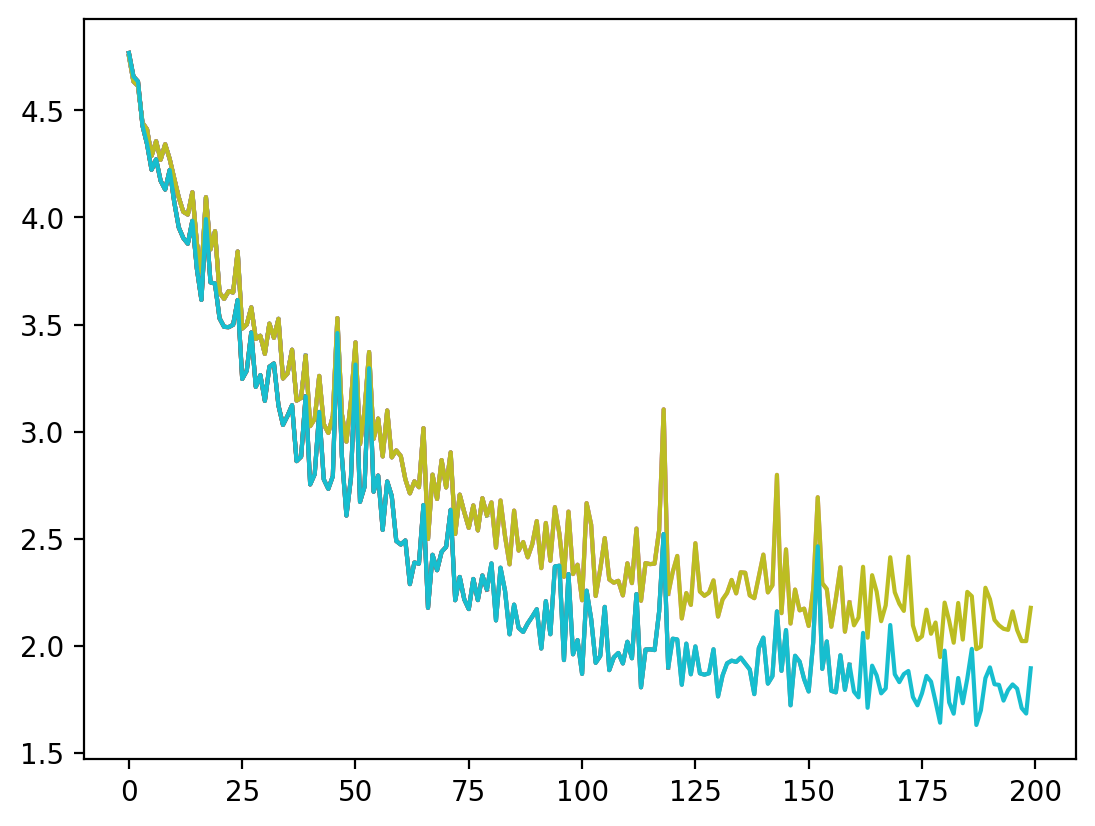

In [21]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.95, weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

try:
    base, train_loss_list, val_loss_list = train_baseline(model, train_iter, val_iter, optimizer, EPOCHS)
    torch.save(base,'baseline.pt')
    
    train_loss_msg = str(train_loss_list[-5])
    # val_loss_msg = str(val_loss_list[-5])
    
    for i in range(-4, 0):
        train_loss_msg += f' ---> {train_loss_list[i]}'
        # val_loss_msg += f' ---> {val_loss_list[i]}'
    
    post_msg = f'학습이 완료되었습니다\ntrain loss : {train_loss_msg}\nmin val loss : {min(val_loss_list)}\n ephoc of best val loss : {val_loss_list.index(min(val_loss_list))}'
    res_ = post_message(config.token, config.channel_id, post_msg)

    # with tempfile.TemporaryDirectory() as tempDir:
    #     if os.path.exists(tempDir):
    #         plt.plot(train_loss_list)
    #         plt.plot(val_loss_list)
    #         plt.savefig(f'{tempDir}/val_plot.png')
    #         with open(f'{tempDir}/val_plot.png', 'rb') as f:
    #             content = f.read()
    #             # print('temp dir: ', tempDir)
    #             # post_message(config.token, config.channel_id, content)
    #             post_file(config.user_token, config.channel_id, f.name, content)
    #             # print(f.name)


except Exception as e:
    res_ = post_message(config.token, config.channel_id, f'Error : {e}')
    print(e)

